# Modeling

In [1]:
import os
import sys
sys.path.insert(0, "../../")

import mpld3
mpld3.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

from core import util, config, database
from core.data.model import ModelDataRepo
from core.data.model.entities import *

database.init()
config.init_plot()

### Get Data

In [2]:
selected_kabko = "KOTA SURABAYA"
kabko = ModelDataRepo.get_kabko_full(selected_kabko)

### Make Model

In [3]:
from core.modeling import SeicrdRlcModel

mod = SeicrdRlcModel(kabko)

### Select Datsets to Use for Fitting

In [4]:
used_datasets = [
    "infectious", 
    "critical_cared", 
    "recovered", 
    "dead",
    #"infected"
]
mod.use_datasets(used_datasets)

### List Variables that Can be Fitted

In [5]:
varying_init = [
    "incubation_period", 
    "r_over", 
    "test_coverage_0",
    "test_coverage_max", "test_coverage_increase", 
    "kapasitas_rs_mul", 
    "critical_time", "critical_chance",
    "death_time_normal", "death_chance_normal", 
    "k", "r_0", "r_1", "r_2"
]

### Select Variables to Fit

In [6]:
varying_now = [
    #"r_over", 
    #"test_coverage_max", "test_coverage_increase", 
    #"test_coverage_0"
    #"kapasitas_rs_mul", 
    "incubation_period", 
    "critical_time", "critical_chance",
    "death_time_normal", "death_chance_normal", 
    "k", "r_0", "r_1", "r_2"
]
unvary = [x for x in varying_init if x not in varying_now]

### Fit!

In [7]:
results = mod.fit(splits=[1], unvary=unvary)
results

[[<core.modeling.fitting_result.FittingResult at 0xc08f288>]]

### Fit Results

In [8]:
latest_result = results[-1][-1]
latest_result

Params Should Have "standard error" and "relative error" Columns. If they dont:
1. A parameter might not be significant
2. A parameter has hit its min/max limit and can't vary

In [9]:
latest_result.result.params

name,value,standard error,relative error,initial value,min,max,vary
days,116.000000,0.00000000,(0.00%),116,-inf,inf,False
population,2904751.00,0.00000000,(0.00%),2904751,-inf,inf,False
incubation_period,5.42283508,179.016787,(3301.17%),5.422835081649804,3.00000000,14.0000000,True
critical_chance,0.41462595,0.09557889,(23.05%),0.4146259488250558,0.01000000,0.41462596,True
critical_time,10.2758525,3.60220431,(35.06%),10.275852459444154,3.00000000,12.0000000,True
recovery_time_normal,9.00000000,0.00000000,(0.00%),9.0,-inf,inf,False
recovery_time_critical,6.50000000,0.00000000,(0.00%),6.5,-inf,inf,False
death_chance_normal,0.45064641,0.45404031,(100.75%),0.4506464143611402,0.00500000,0.45064725,True
death_time_normal,6.38729960,7.52308165,(117.78%),6.387299598030198,5.00000000,10.0000000,True
death_chance_over,1.00000000,0.00000000,(0.00%),1.0,-inf,inf,False


How did we fit many datasets at once? Well, just concat them, as shown in the plot below.

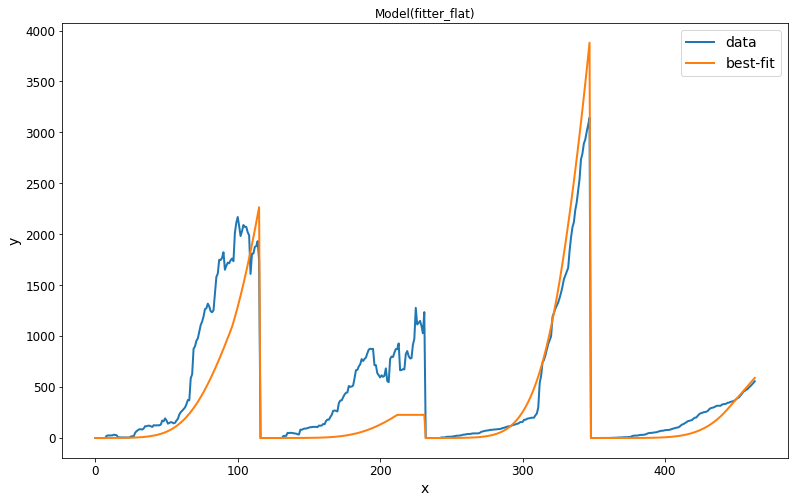

In [10]:
latest_result.result.plot_fit(datafmt="-");

### Model Scores

In [11]:
latest_scorer = latest_result.scorer()
scorer_flat = latest_scorer.scorer_flat
train_scorer = scorer_flat.train_scorer

In [12]:
train_scorer.mean_absolute_error()

206.42388550627044

In [13]:
train_scorer.explained_variance_score()

0.791120257863911

### Predict

In [14]:
values = dict(latest_result.result.values)
values["days"] += 30
model_result = mod.model(**values)

### Plot!

In [15]:
from core.modeling import ModelPlotter

plotter = ModelPlotter(model_result)

In [16]:
shift = kabko.outbreak_shift(kabko.params["incubation_period"].init)
shift

5

In [17]:
length = kabko.data_count + shift
length

116

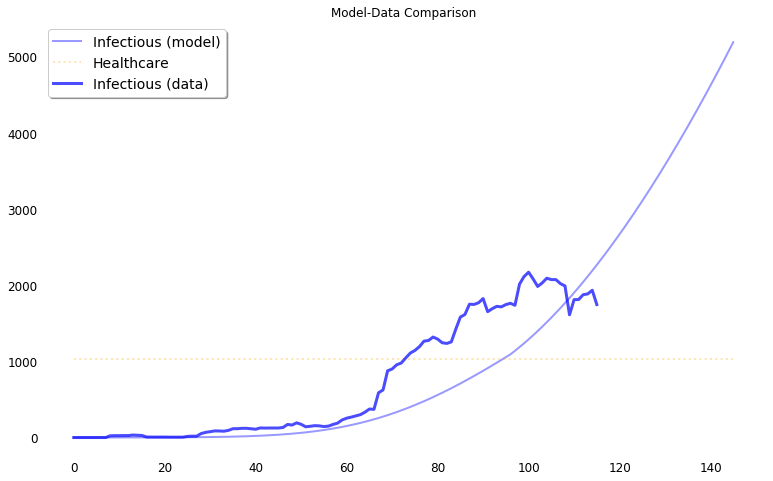

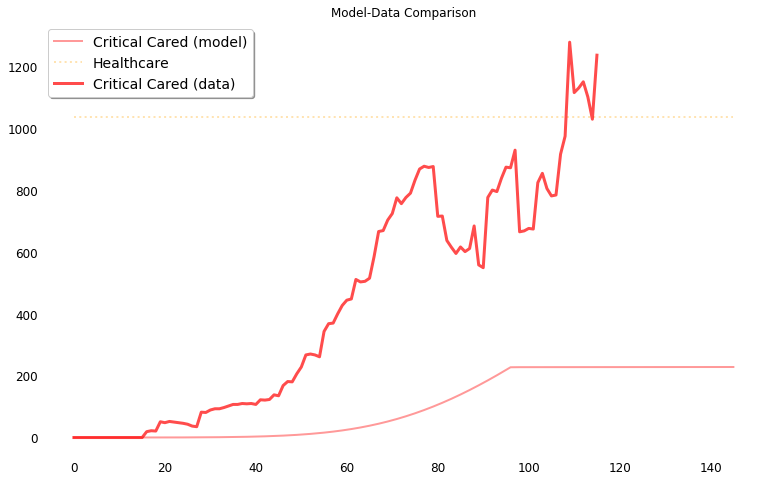

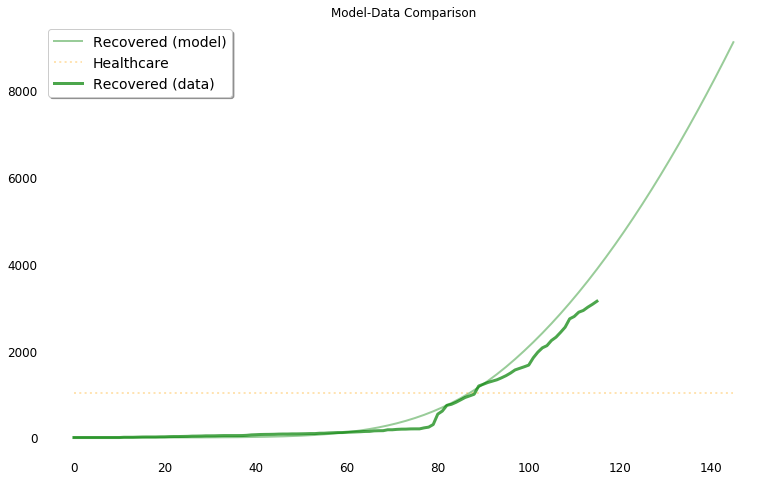

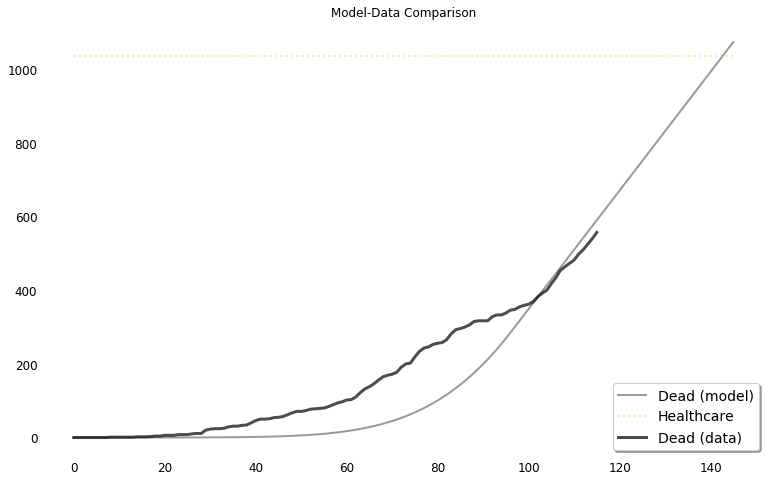

In [18]:
import matplotlib.pyplot as plt
for d in used_datasets:
    datasets = kabko.get_datasets([d], shift)
    plotter.plot(
        plotter.plot_main_data, 
        datasets,
        length
    )
    plt.show()

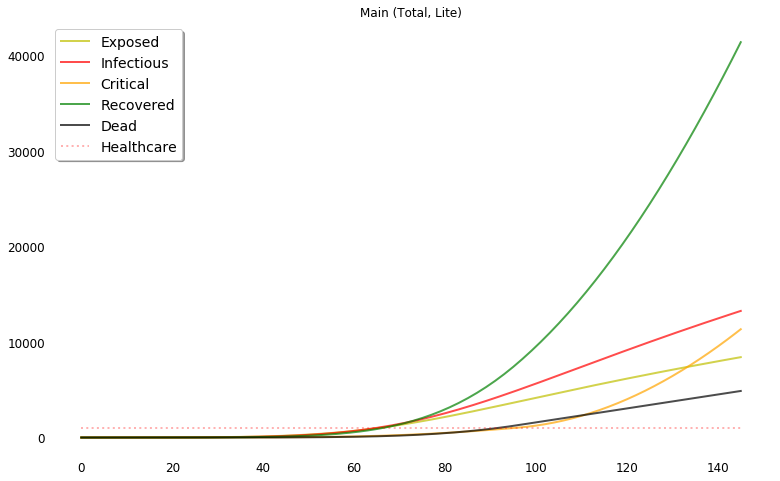

In [19]:
plotter.plot(plotter.plot_main_lite);

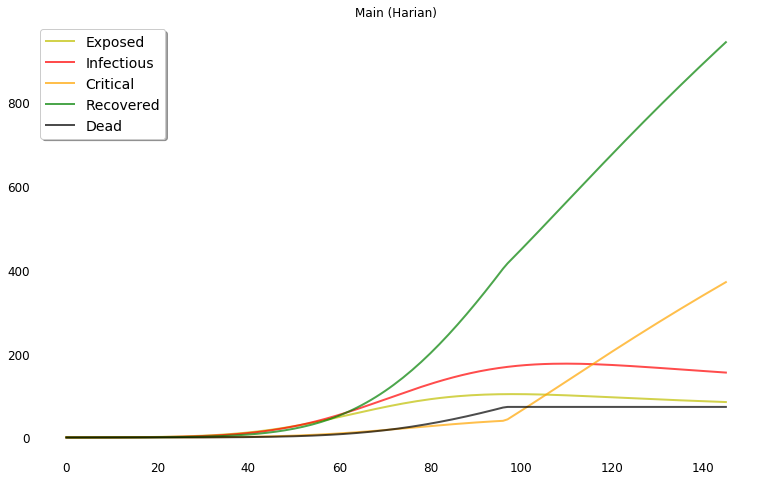

In [20]:
plotter.plot(plotter.plot_daily_lite);

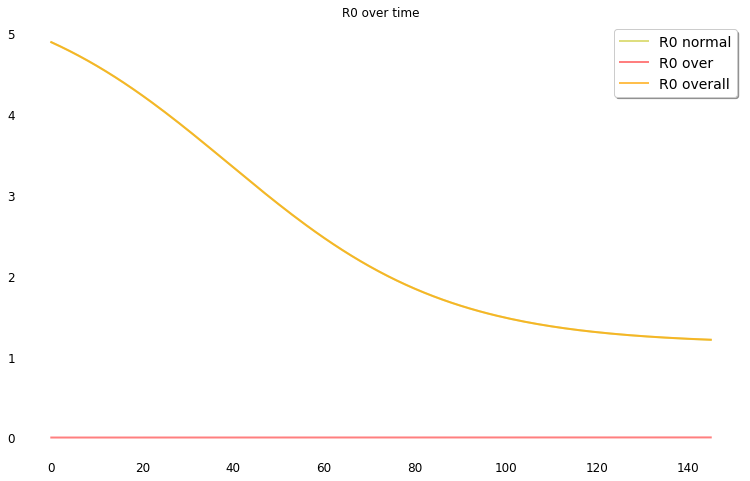

In [21]:
plotter.plot(plotter.plot_r0);

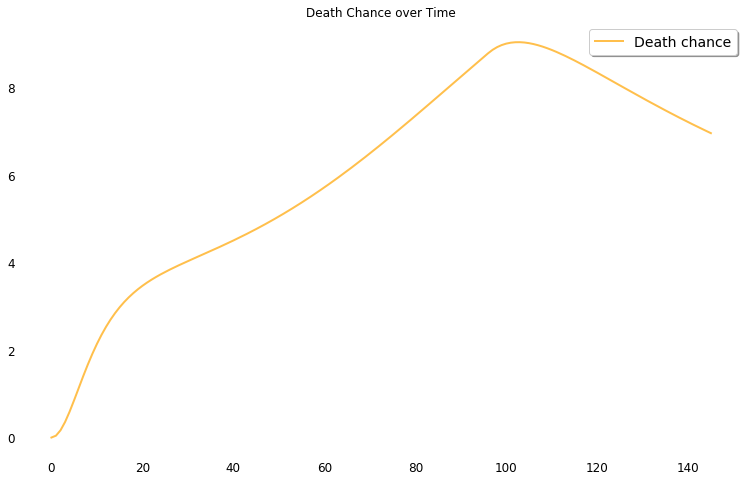

In [22]:
plotter.plot(plotter.plot_death_chance);

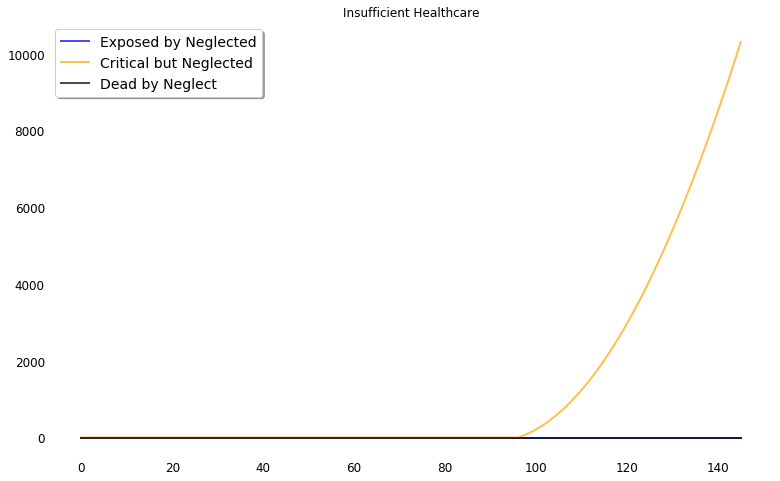

In [23]:
plotter.plot(plotter.plot_over);

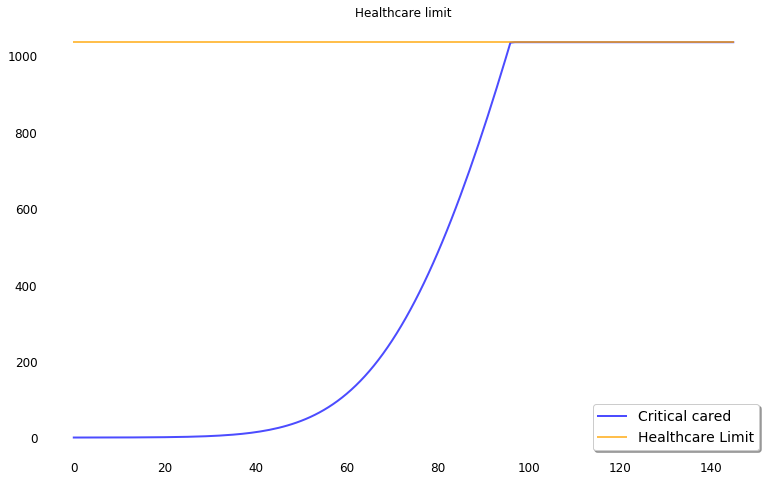

In [24]:
plotter.plot(plotter.plot_healthcare);

### Save Params

In [25]:
ModelDataRepo.update_params_rt(kabko, latest_result.result.values)

### Confidence Interval

This requires standard error to be present for each params.

latest_result.result.conf_interval()